In [1]:
from astropy import units as uu
region_name = "TDS" # _ELAISN1
radius = 5 * uu.arcsec

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
from regions import CircleSkyRegion
from astropy.coordinates import SkyCoord
from astropy.wcs.utils import pixel_to_skycoord
import numpy as np
from vasca.region import Region
from vasca.field import BaseField
import vasca.visualization as vvis
from astroquery.simbad import Simbad

#Load region
region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
rg = Region()
rg.load_from_fits(region_fname)
sel_src = rg.tt_sources["sel"]
tt_src = rg.tt_sources[sel_src]
display(tt_src[:2])
src_coord = SkyCoord(tt_src["ra"].quantity,tt_src["dec"].quantity,frame='icrs')
print(src_coord[:2])

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,assoc_id,assoc_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,assoc_ffactor,assoc_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32
-1,46 .. 5,334.64049826925117,0.4526866937010489,0.09875569,-0.23671262,0.2647861,0.9968758,0.5008254,14,0.08471,1 .. 2,True,9.525185 .. 5.7065663,0.13788767 .. 0.29823554,0.036390573 .. 0.013060489,4.2145147 .. 0.9072336,1.1285862e-24 .. 0.14995933,4.8611155 .. 1.6863966,0.9958173 .. 0.9101466,-0.22837132 .. -1.1546247,-1,8,4
-1,72 .. 5,334.60403128211425,0.40736589666436374,0.06406002,-0.17132753,0.15922262,0.99998045,0.45087305,23,0.14243871,1 .. 2,True,70.01522 .. 3.1264899,0.19698732 .. 0.23375492,0.00093811314 .. 0.013469439,7.4774384 .. 0.49470344,1.256716e-12 .. 0.27841964,2.6584294 .. 1.2719177,0.9798159 .. 0.954735,-5.3000717 .. -0.42171407,-1,13,4


<SkyCoord (ICRS): (ra, dec) in deg
    [(334.64049827, 0.45268669), (334.60403128, 0.4073659 )]>


In [3]:
customSimbad = Simbad()
customSimbad.add_votable_fields('typed_id','otype',"otype(opt)","otypes")
tt_matches= customSimbad.query_region(src_coord,radius=radius)
display(tt_matches)
#tt_objects = Simbad.query_objects(tt_matches["MAIN_ID"])


MAIN_ID,RA,DEC,RA_PREC,DEC_PREC,COO_ERR_MAJA,COO_ERR_MINA,COO_ERR_ANGLE,COO_QUAL,COO_WAVELENGTH,COO_BIBCODE,TYPED_ID,OTYPE,OTYPE_opt,OTYPES,SCRIPT_NUMBER_ID
,"""h:m:s""","""d:m:s""",,,mas,mas,deg,,,,,,,,
object,str13,str13,int16,int16,float32,float32,int16,str1,str1,object,object,object,object,object,int32
SDSS J221833.73+002709.2,22 18 33.7383,+00 27 09.244,14,14,0.739,0.787,90,A,O,2020yCat.1350....0G,,QSO,QSO,AGN|QSO|QSO|QSO|*|G|G|Opt,1
2MASS J22182502+0024270,22 18 25.0423,+00 24 26.465,14,14,0.158,0.164,90,A,O,2020yCat.1350....0G,,QSO,QSO,QSO|QSO|AGN|QSO|QSO|QSO|NIR|*|*|AG?|Opt|X|X,2
SDSS J221712.61-002502.8,22 17 12.6032,-00 25 02.818,14,14,1.843,1.024,90,A,O,2020yCat.1350....0G,,QSO,QSO,QSO|AGN|QSO|QSO|AGN|*|Opt|X|X,3
SDSS J160857.64+542121.7,16 08 57.642,+54 21 21.70,7,7,--,--,0,C,O,2017A&A...597A..79P,,QSO,QSO,QSO|QSO|QSO|Opt,4
ELAISC15 J160835+542328,16 08 35.6509,+54 23 29.450,14,14,0.100,0.116,90,A,O,2020yCat.1350....0G,,QSO,QSO,AGN|QSO|*|IR|Opt|X,5
SDSS J160734.55+553800.8,16 07 34.5587,+55 38 00.896,14,14,0.200,0.202,90,A,O,2020yCat.1350....0G,,QSO,QSO,QSO|QSO|QSO|*|Opt,7
SDSS J160716.15+541425.9,16 07 16.154,+54 14 25.90,7,7,--,--,0,C,O,2020ApJS..250....8L,,QSO,QSO,QSO|Opt,8
ICRF J160623.5+540555,16 06 23.5659,+54 05 55.759,14,14,0.060,0.054,90,A,O,2020yCat.1350....0G,,Seyfert1,Sy1,AGN|Bla|QSO|QSO|Bla|QSO|Bla|QSO|MIR|NIR|Bla|Sy1|*|IR|Opt|Rad|Rad|Rad|Rad|UV|X|X,9


In [14]:
#print(tt_matches["OTYPE_opt"].data)
otypes, otype_cts= np.unique(tt_matches["OTYPE_opt"],return_counts=True)
print(otypes,otype_cts )

OTYPE_opt
---------
        *
        ?
      AG?
      AGN
      BLL
      BiC
      CV*
      ClG
      EB*
      EmG
        G
      GiC
      GrG
      HB*
       IR
      LI?
      LM*
      LP*
      LP?
      Le?
      PM*
      Pu*
       Q?
      QSO
      RG*
      RR*
      Rad
      SB*
      SN*
      Sy1
      SyG
       V*
      WD*
      WD?
        X
      blu
      dS*
       ev
       rG [ 26   2   3  40   6   1   2   6  13   7 167   1   3   2   2   1   1   1
   2   1   3   4   1 559   1  34  10   3   8  49   1   1   1   1   8   9
   3   3   2]


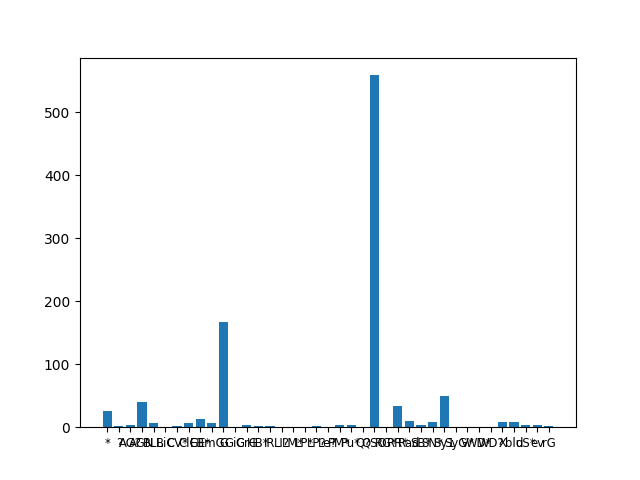

In [18]:
plt.bar( range(len(otypes)), otype_cts, align='center')
plt.xticks(range(len(otypes)), otypes, size='small')
plt.show()

Le?     	Possible gravitational lens    
PM*     	High proper-motion Star   
Pu*     	Pulsating variable Star 
Q?      	Possible Quasar  
QSO     	Quasar 
RG*     	Red Giant Branch star  
RR*     	Variable Star of RR Lyr type 
Rad     	Radio-source
SB*     	Spectroscopic binary     
SN*     	SuperNova
Sy1     	Seyfert 1 Galaxy 
SyG     	Seyfert Galaxy
V*      	Variable Star  
WD*     	White Dwarf
WD?     	White Dwarf Candidate    
X      	X-ray source
blu     	Blue object 
dS*     	Variable Star of delta Sct type  
ev      	transient event 
rG      	Radio Galaxy   

In [6]:
Simbad.get_field_description('otypes')

list of (secondary) object types for one object


In [7]:
from astroquery.simbad import Simbad

Simbad.add_votable_fields('typed_id')

result_table = Simbad.query_objects(["M1", "M2", "M3", "M4"])

print(result_table)

MAIN_ID      RA         DEC     RA_PREC DEC_PREC COO_ERR_MAJA COO_ERR_MINA COO_ERR_ANGLE COO_QUAL COO_WAVELENGTH     COO_BIBCODE     TYPED_ID SCRIPT_NUMBER_ID
          "h:m:s"     "d:m:s"                        mas          mas           deg                                                                           
------- ----------- ----------- ------- -------- ------------ ------------ ------------- -------- -------------- ------------------- -------- ----------------
  M   1  05 34 30.9   +22 00 53       5        5    18500.000    18500.000             0        E              R 1995AuJPh..48..143S       M1                1
  M   2 21 33 27.02 -00 49 23.7       6        6           --           --             0        D              O 2010AJ....140.1830G       M2                2
  M   3 13 42 11.62 +28 22 38.2       6        6           --           --             0        D              O 2010AJ....140.1830G       M3                3
  M   4 16 23 35.22 -26 31 32.7       6       